# Model Explainability & Business Insights


Loading data and model...
Making predictions...
Finding optimal intervention threshold...
Analyzing business impact...
/n BUSINESS IMPACT REPORT
Current Situation:
  • Monthly no-shows cost: $218,500
  • No-show rate: 29.1%

Recommended Strategy:
  • Target patients with ≥10% risk
  • High-risk patients identified: 3,000
  • Monthly net savings: $24,330
  • Return on investment: 1.6x
Creating visual insights...


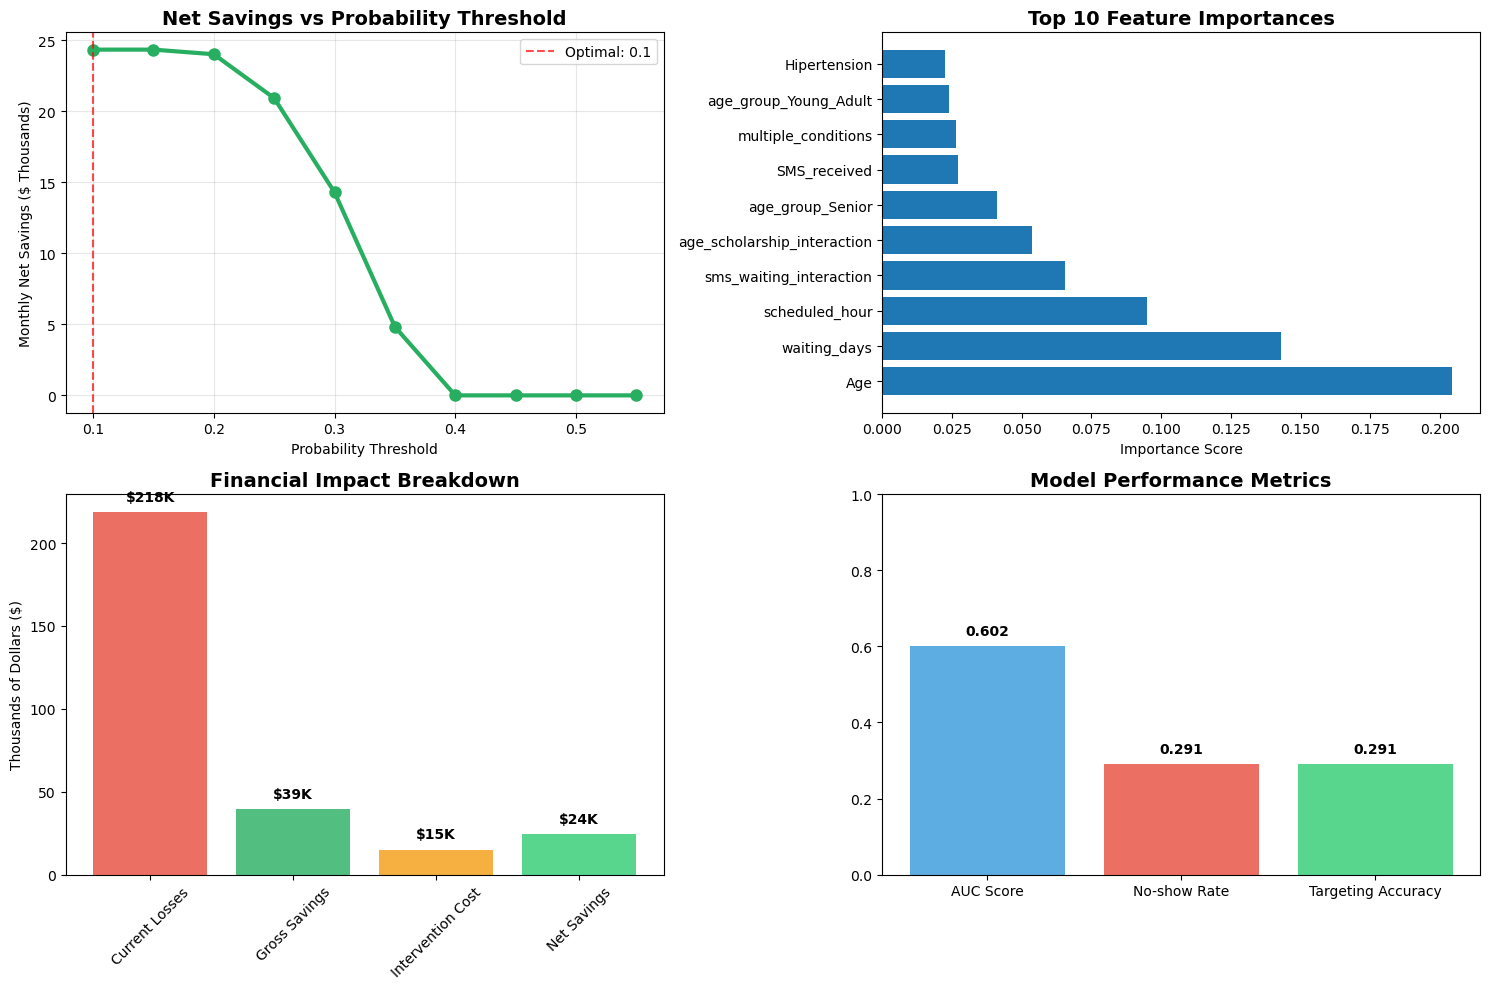

Saving results...
✓ Analysis complete:
  - 200 high-priority patients identified
  - Executive summary saved
  - Business dashboard created

SUMMARY:

• Model Performance: AUC = 0.602
• Optimal Strategy: Target patients with ≥10% no-show probability  
• High-Risk Patients: 3,000 identified
• Monthly Net Savings: $24,330
• Annual Impact: $291,960
• ROI: 1.6x



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.metrics import accuracy_score, roc_auc_score

print("Loading data and model...")
df = pd.read_csv('../data/cleaned_medical_noshow.csv', nrows=3000)
model = joblib.load('../models/best_model_random_forest.pkl')
feature_names = joblib.load('../models/feature_names.pkl')

# Create missing features
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['scheduled_hour'] = df['ScheduledDay'].dt.hour

for feature in feature_names:
    if feature not in df.columns:
        df[feature] = 0

X = df[feature_names]
y = df['no_show_binary']

print("Making predictions...")
y_pred_proba = model.predict_proba(X)[:, 1]
roc_auc = roc_auc_score(y, y_pred_proba)

print("Finding optimal intervention threshold...")
thresholds = np.arange(0.1, 0.6, 0.05) 
results = []

COST_PER_MISSED = 150
INTERVENTION_COST = 5
EFFECTIVENESS = 0.3

for threshold in thresholds:
    high_risk_mask = y_pred_proba >= threshold
    high_risk_count = high_risk_mask.sum()
    
    if high_risk_count > 0:
        high_risk_accuracy = y[high_risk_mask].mean()
        preventable = high_risk_count * high_risk_accuracy * EFFECTIVENESS
        savings = preventable * COST_PER_MISSED
        cost = high_risk_count * INTERVENTION_COST
        net_savings = savings - cost
        roi = (net_savings / cost) if cost > 0 else 0
    else:
        high_risk_accuracy = 0
        net_savings = 0
        roi = 0
    
    results.append({
        'threshold': threshold,
        'high_risk_count': high_risk_count,
        'targeting_accuracy': high_risk_accuracy,
        'net_savings': net_savings,
        'roi': roi
    })

results_df = pd.DataFrame(results)
optimal_idx = results_df['net_savings'].idxmax()
optimal_threshold = results_df.loc[optimal_idx, 'threshold']
optimal_savings = results_df.loc[optimal_idx, 'net_savings']
optimal_high_risk = results_df.loc[optimal_idx, 'high_risk_count']
optimal_accuracy = results_df.loc[optimal_idx, 'targeting_accuracy']

print("Analyzing business impact...")
current_no_show_rate = y.mean()
PATIENTS_PER_MONTH = 5000
monthly_loss = PATIENTS_PER_MONTH * current_no_show_rate * COST_PER_MISSED

print("BUSINESS IMPACT REPORT")

print(f"Current Situation:")
print(f"  • Monthly no-shows cost: ${monthly_loss:,.0f}")
print(f"  • No-show rate: {current_no_show_rate:.1%}")

print(f"\nRecommended Strategy:")
print(f"  • Target patients with ≥{optimal_threshold:.0%} risk")
print(f"  • High-risk patients identified: {optimal_high_risk:,}")
print(f"  • Monthly net savings: ${optimal_savings:,.0f}")
print(f"  • Return on investment: {results_df.loc[optimal_idx, 'roi']:.1f}x")

print("Creating visual insights...")
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Threshold vs Savings
ax1.plot(results_df['threshold'], results_df['net_savings']/1000, 
         marker='o', linewidth=3, markersize=8, color='#27ae60')
ax1.axvline(optimal_threshold, color='red', linestyle='--', alpha=0.7, 
           label=f'Optimal: {optimal_threshold}')
ax1.set_title('Net Savings vs Probability Threshold', fontweight='bold', fontsize=14)
ax1.set_xlabel('Probability Threshold')
ax1.set_ylabel('Monthly Net Savings ($ Thousands)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

ax2.barh(range(len(feature_importance)), feature_importance['importance'])
ax2.set_yticks(range(len(feature_importance)))
ax2.set_yticklabels(feature_importance['feature'])
ax2.set_title('Top 10 Feature Importances', fontweight='bold', fontsize=14)
ax2.set_xlabel('Importance Score')

# Plot 3: Financial Impact Breakdown
categories = ['Current Losses', 'Gross Savings', 'Intervention Cost', 'Net Savings']
values = [
    monthly_loss/1000,
    (optimal_high_risk * optimal_accuracy * EFFECTIVENESS * COST_PER_MISSED)/1000,
    (optimal_high_risk * INTERVENTION_COST)/1000,
    optimal_savings/1000
]
colors = ['#e74c3c', '#27ae60', '#f39c12', '#2ecc71']
bars = ax3.bar(categories, values, color=colors, alpha=0.8)
ax3.set_title('Financial Impact Breakdown', fontweight='bold', fontsize=14)
ax3.set_ylabel('Thousands of Dollars ($)')
ax3.tick_params(axis='x', rotation=45)
for bar, value in zip(bars, values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'${value:.0f}K', ha='center', va='bottom', fontweight='bold')

# Plot 4: Model Performance
metrics = ['AUC Score', 'No-show Rate', 'Targeting Accuracy']
metric_values = [roc_auc, current_no_show_rate, optimal_accuracy]
colors = ['#3498db', '#e74c3c', '#2ecc71']

ax4.bar(metrics, metric_values, color=colors, alpha=0.8)
ax4.set_title('Model Performance Metrics', fontweight='bold', fontsize=14)
ax4.set_ylim(0, 1)
for i, (metric, value) in enumerate(zip(metrics, metric_values)):
    ax4.text(i, value + 0.02, f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/final_business_insights.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saving results...")
# Save high-risk patients using optimal threshold
high_risk_mask = y_pred_proba >= optimal_threshold
high_risk_export = df[high_risk_mask][['PatientId', 'AppointmentID']].copy()
high_risk_export['no_show_probability'] = y_pred_proba[high_risk_mask]
high_risk_export = high_risk_export.nlargest(200, 'no_show_probability')
high_risk_export.to_csv('../outputs/high_priority_patients.csv', index=False)

# Enhanced executive summary
executive_summary = pd.DataFrame([{
    'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d'),
    'patients_analyzed': len(df),
    'current_no_show_rate': current_no_show_rate,
    'model_auc_score': roc_auc,
    'optimal_threshold': optimal_threshold,
    'high_risk_patients_identified': optimal_high_risk,
    'targeting_accuracy': optimal_accuracy,
    'monthly_net_savings': optimal_savings,
    'annual_savings_potential': optimal_savings * 12,
    'return_on_investment': results_df.loc[optimal_idx, 'roi'],
    'key_predictor': feature_importance.iloc[0]['feature']
}])
executive_summary.to_csv('../outputs/executive_summary.csv', index=False)

print("✓ Analysis complete:")
print(f"  - {len(high_risk_export):,} high-priority patients identified")
print(f"  - Executive summary saved")
print(f"  - Business dashboard created")

print(f"""
SUMMARY:

• Model Performance: AUC = {roc_auc:.3f}
• Optimal Strategy: Target patients with ≥{optimal_threshold:.0%} no-show probability  
• High-Risk Patients: {optimal_high_risk:,} identified
• Monthly Net Savings: ${optimal_savings:,.0f}
• Annual Impact: ${optimal_savings * 12:,.0f}
• ROI: {results_df.loc[optimal_idx, 'roi']:.1f}x
""")